In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from sklearn import metrics

import pymc3 as pm
import theano.tensor as tt

from matplotlib import pylab as plt
import seaborn as sns
import arviz as az

plt.style.use("bmh")

PLOT_SIZE = (12, 8)


%load_ext watermark
%matplotlib inline

In [2]:
%watermark -v -d -t -z -u -r -iv

sklearn          0.22
numpy            1.17.3
pandas           0.25.2
seaborn          0.9.0
scipy            1.3.1
theano           1.0.4
arviz            0.6.0
pymc3            3.8
matplotlib.pylab 1.17.3
last updated: 2020-01-09 14:18:35 PST 

CPython 3.7.4
IPython 7.9.0
Git repo: git@github.com:clausherther/nfl-analysis.git


### Sampler Settings

In [3]:
SEED = 42

def get_sampler_config(n_draws=2000, n_chains=4, n_cores=4, target_accept=0.95, seed=SEED):

    n_tunes = int(n_draws / 2)
    return {
        "chains": n_chains,
        "cores": n_cores,
        "draws": n_draws,
        "tune": n_tunes,
        "target_accept": target_accept,
        "random_seed": [SEED + s for s in np.arange(0, n_chains)],
    }

get_sampler_config()

{'chains': 4,
 'cores': 4,
 'draws': 2000,
 'tune': 1000,
 'target_accept': 0.95,
 'random_seed': [42, 43, 44, 45]}

### Helper Functions

In [4]:
def get_column_encoding(col):
    enc = OrdinalEncoder()
    enc.fit(col)
    idx = get_column_indexes(enc, col)
    return enc, idx

def get_column_indexes(enc, col):
    return enc.transform(col).ravel().astype(int)

def make_ref_val(df, var_name, group_name, ref_col):
    """
    Helper function to create ref_val dict
    needed by ArViz
    """
    return {var_name: [{group_name: g, "ref_val": r} for g, r in df[[group_name, ref_col]].values]}


def make_az_data(trace, ppc, var_name, col_name, col_values):
    """
    Helper function to ArViz data object
    from trace
    """    
    return az.from_pymc3(trace=trace,
                         posterior_predictive=ppc,
                         coords={col_name: col_values},
                         dims={var_name: [col_name]},
      )

## Get Data

We've previously sourced this data from the `nfl-dbt` repo.

In [5]:
df = pd.read_hdf("data/field_goals.hd5", "field_goals")

Baseline Field Goal % is:

In [6]:
mean_p = df["successful_field_goals"].sum()/df["field_goals"].sum()
f"Baseline Field Goal %: {mean_p:%}"

'Baseline Field Goal %: 83.386111%'

We notice we have an imbalanced dataset, with over 80% of field goals being made. However, since we're not interested in predicting a binary response, instead we're interested in the predicted probabilities, this should not pose a problem for us. 

### Make Training Dataframe

The longest field goal attempt was from 71 yards, the longest successful one from 64 yards:

In [85]:
df["kick_distance_yards"].max(), df.query("successful_field_goals > 0")["kick_distance_yards"].max()

(71.0, 64.0)

In [196]:
df[["play_id", "kick_distance_yards", "is_field_goal_success"]].set_index("play_id").sample(10)

,kick_distance_yards,is_field_goal_success
play_id,,
2278,19.0,True
1336,35.0,True
3290,54.0,True
3034,50.0,True
1121,46.0,False
3687,50.0,True
1964,51.0,True
2826,22.0,True
459,25.0,True


Let's quickly group this data by kick distance to get an idea of success rate from various distances:

In [87]:
df_grp = (df.groupby(["kick_distance_yards", 
                      "kick_angle_horizontal", "kick_angle_vertical", 
                      "kick_angle_horizontal_degrees", "kick_angle_vertical_degrees"])[["field_goals", "successful_field_goals"]]
     .sum()
     .reset_index()
        )   
df_grp["field_goals_success_percent"] = df_grp["successful_field_goals"]/df_grp["field_goals"]
df_grp.tail(10)        

,kick_distance_yards,kick_angle_horizontal,kick_angle_vertical,kick_angle_horizontal_degrees,kick_angle_vertical_degrees,field_goals,successful_field_goals,field_goals_success_percent
43,61.0,0.099820,0.188975,5.719246,10.827453,20,6,0.300000
44,62.0,0.098249,0.185997,5.629262,10.656848,13,3,0.230769
45,63.0,0.096727,0.183111,5.542031,10.491477,17,4,0.235294
46,64.0,0.095250,0.180312,5.457431,10.331105,5,1,0.200000
47,65.0,0.093817,0.177596,5.375346,10.175511,2,0,0.000000
48,66.0,0.092427,0.174960,5.295667,10.024487,6,0,0.000000
49,67.0,0.091076,0.172401,5.218290,9.877836,2,0,0.000000
50,68.0,0.089764,0.169914,5.143118,9.735374,1,0,0.000000
51,69.0,0.088489,0.167498,5.070059,9.596924,1,0,0.000000
52,71.0,0.086044,0.162864,4.929939,9.331411,1,0,0.000000


In [198]:
df_grp[["kick_distance_yards", "field_goals", "successful_field_goals"]].head(10).set_index("kick_distance_yards")

,field_goals,successful_field_goals
kick_distance_yards,,
18.0,17,17
19.0,123,123
20.0,251,249
21.0,300,294
22.0,332,326
23.0,368,362
24.0,294,282
25.0,358,354
26.0,317,307


In [9]:
def plot_kick_data(df, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
    sns.scatterplot("kick_distance_yards", "field_goals_success_percent", size="field_goals", data=df, label="observed", ax=ax);
    
    vals = ax.get_yticks()
    _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_xlabel("Yards Kicked")
    ax.set_ylabel("Field Goal Success %")
    _ = ax.set_title("Field Goal % by Yards Kicked")
    
    return ax


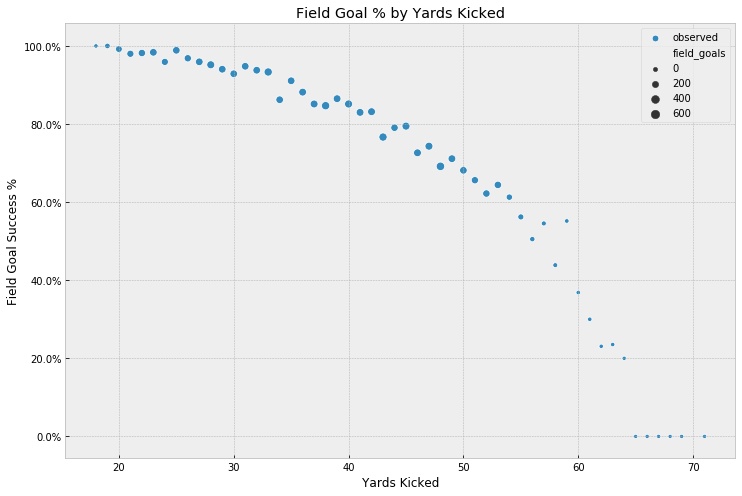

In [10]:
_ = plot_kick_data(df_grp)

We can see that after 55+ yards it gets pretty thin but still directional.

In 2014, a rule change increased the height of the field by 5ft, so for training, let's only look at seasons since then.

We'll also exlude any attempts from more than 63 yards out.

In [11]:
season_cutoff = 2014
yards_cutoff = 63
df_train = df.query(f"season_nbr >= {season_cutoff} and kick_distance_yards <= {yards_cutoff}").copy()[
    ["yardline_100", "kick_distance_yards", 
     "kick_angle_horizontal", "kick_angle_vertical", 
     "kick_angle_horizontal_degrees", "kick_angle_vertical_degrees",
     "quarter", "season_type_code", "is_field_goal_success", "field_goals", "successful_field_goals"]
]

In [12]:
df_train_yards = (
    df_train
     .groupby(["kick_distance_yards", 
               "kick_angle_horizontal", "kick_angle_vertical",
               "kick_angle_horizontal_degrees", "kick_angle_vertical_degrees"])[["field_goals", "successful_field_goals"]]
     .sum()
     .reset_index()
)
df_train_yards["field_goals_success_percent"] = df_train_yards["successful_field_goals"]/df_train_yards["field_goals"]

In [13]:
df_train_yards.tail()

,kick_distance_yards,kick_angle_horizontal,kick_angle_vertical,kick_angle_horizontal_degrees,kick_angle_vertical_degrees,field_goals,successful_field_goals,field_goals_success_percent
41,59.0,0.103114,0.195222,5.908006,11.185377,17,9,0.529412
42,60.0,0.101441,0.192048,5.812115,11.003541,11,4,0.363636
43,61.0,0.099820,0.188975,5.719246,10.827453,8,3,0.375000
44,62.0,0.098249,0.185997,5.629262,10.656848,9,3,0.333333
45,63.0,0.096727,0.183111,5.542031,10.491477,12,2,0.166667


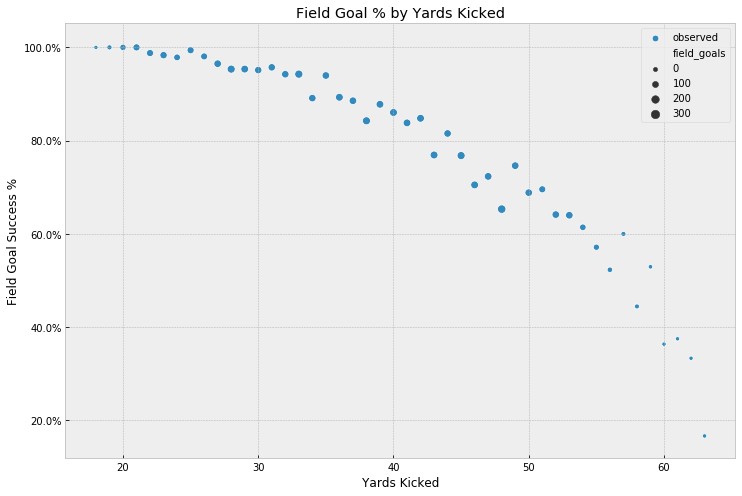

In [14]:
plot_kick_data(df_train_yards);

### Baseline Model (1) - Yards

For our first model, we'll build a logistic regression model with a Binomial likelihood to determine the effect of kicking distance on the field goal success rate:

In [69]:
X = df_train_yards["kick_distance_yards"].values
n = df_train_yards["field_goals"].values
y = df_train_yards["successful_field_goals"].values

In [70]:
with pm.Model() as model_logit_yards:
    
    α = pm.Normal("α", mu=0, sd=1)
    β = pm.Normal("β", mu=0, sd=1)

    z = α + β * X
    p = pm.Deterministic("p", pm.math.invlogit(z))

    y_obs = pm.Binomial("y_obs",n=n, p=p, observed=y)

In [71]:
model_logit_yards

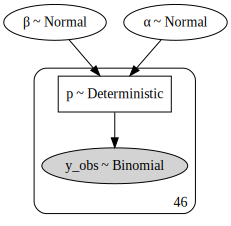

In [72]:
pm.model_to_graphviz(model_logit_yards)

In [78]:
with model_logit_yards:
    trace_logit_yards = pm.sample(**get_sampler_config(4000), init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:12<00:00, 1875.45draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [79]:
pm.summary(trace_logit_yards, var_names=["α", "β"], kind="stats")

,mean,sd,hpd_3%,hpd_97%
α,6.073,0.179,5.736,6.409
β,-0.107,0.004,-0.114,-0.099


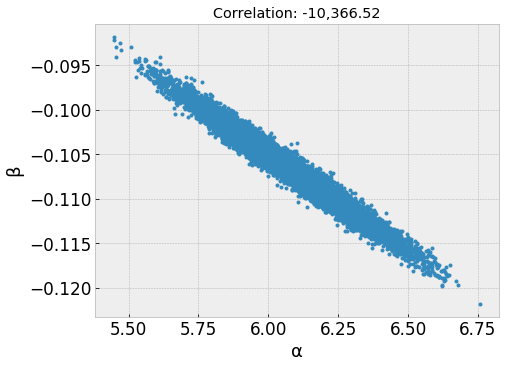

In [80]:
ax = pm.plot_pair(trace_logit_yards, var_names=["α", "β"], figsize=(7, 5));
corr = np.correlate(trace_logit_yards["α"], trace_logit_yards["β"])[0]
ax.set_title(f"Correlation: {corr:,.2f}");

/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


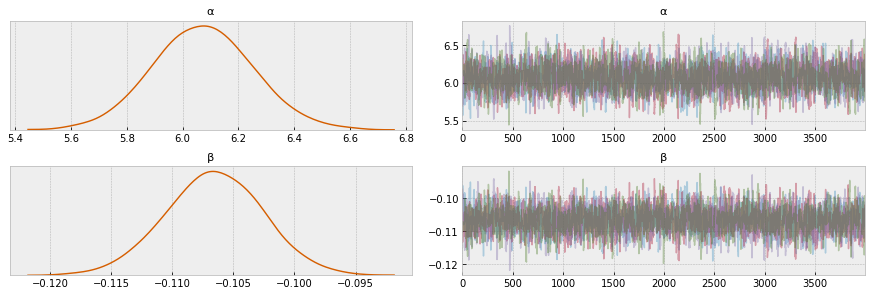

In [81]:
az.plot_trace(trace_logit_yards, combined=True, compact=True, var_names=["α", "β"], divergences=None);

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

One thing to note here, is the field goal % from the closest feasible distance attempted is just over 98.4%, not 100%.

In [82]:
yards = df_train_yards["kick_distance_yards"].min()
yards, sigmoid(trace_logit_yards["α"]+ trace_logit_yards["β"] * yards).mean()

(18.0, 0.9844718419294534)

Even from a theoretical 0 yards out, we only get close to 100%:

In [89]:
yards = 0
sigmoid(trace_logit_yards["α"] + trace_logit_yards["β"] * yards).mean()

0.9976655255893969

Let's plot the model's output against our observed % to see how we did:

In [28]:
def plot_probs_yard(df, probas_posterior, model_name, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
    
    ax.plot(df["kick_distance_yards"], probas_posterior.mean(axis=0), color="k", label=f"{model_name}", linestyle="dotted")
    az.plot_hpd(df["kick_distance_yards"], probas_posterior, credible_interval=.95, ax=ax, fill_kwargs={'alpha': .2})
    
    _ = plot_kick_data(df, ax)
    ax.set_title(f"{ax.get_title()} - {model_name}") ;
    
    return ax

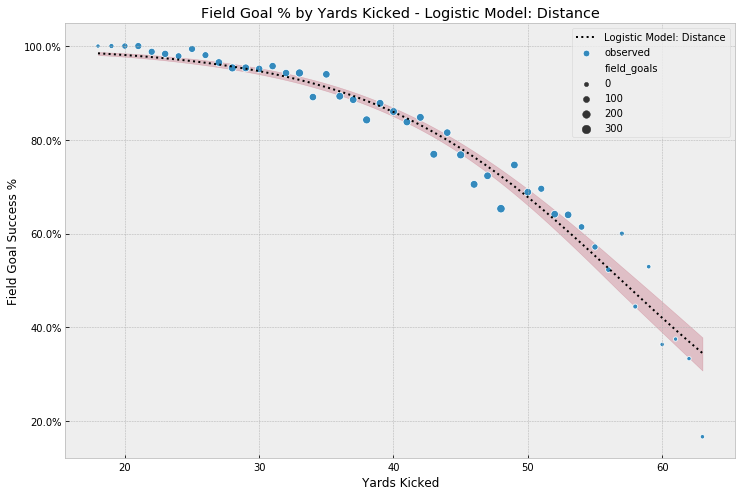

In [29]:
ax = plot_probs_yard(df_train_yards, trace_logit_yards["p"], "Logistic Model: Distance")

### Geometry-based Model

In [30]:
DISTANCE_FROM_GOAL_YRDS = 10.0 # yards
DISTANCE_TO_HASHMARK_FT = 10.75 # feet
GOAL_WIDTH_FT = 18.5
GOAL_HEIGHT_FT = 35.0

from scipy.special import erf

def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * erf(x / np.sqrt(2.))

def get_kick_angle_horiz(distance_yards):
    adjacent_ft = distance_yards*3
    opposite_ft_total = DISTANCE_TO_HASHMARK_FT + GOAL_WIDTH_FT
    opposite_ft_side = DISTANCE_TO_HASHMARK_FT

    β = np.arctan(opposite_ft_total/adjacent_ft)
    α = np.arctan(opposite_ft_side/adjacent_ft)
    return β - α

def get_kick_angle_vert(d):
    
    adjacent_ft = d*3
    α = np.arctan(GOAL_HEIGHT_FT/adjacent_ft)
    return α

def radiants_to_degrees(y):
    return (y*180.0/np.pi)

def degrees_to_radiants(y):
    return (y/180.0*np.pi)

def kick_angle_model_horiz(distance, sigma):
    angle = get_kick_angle_horiz(distance)
#     cdf = stats.norm.cdf(h, 0, sigma)
    return (2 * Phi(angle/sigma) - 1)

def kick_angle_model_vert(distance, sigma):
    angle = get_kick_angle_vert(distance)
    
#     norm = stats.norm(0, sigma)
#     cdf = stats.norm.cdf(v, 0, sigma)
    return (1 - (2 * Phi(angle/sigma) - 1))
    
def kick_angle_model(distance, sigma):
    return kick_angle_model_horiz(distance, sigma) * kick_angle_model_vert(distance, sigma)





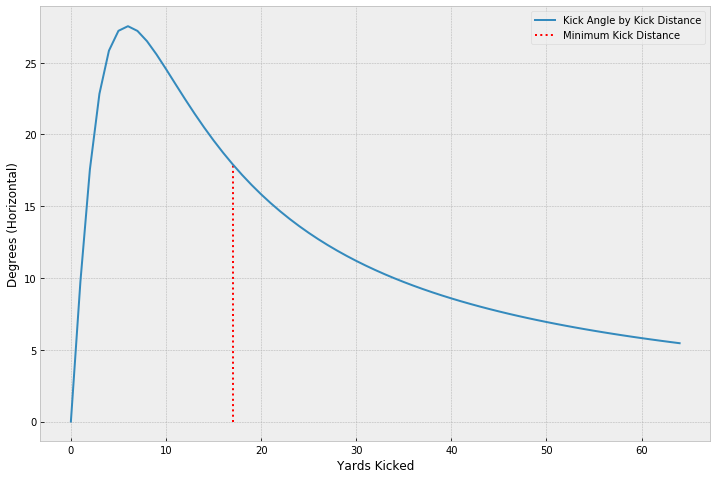

In [109]:
d = np.arange(0, 65, 1)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
ax.plot(d, radiants_to_degrees(get_kick_angle_horiz(d)), label="Kick Angle by Kick Distance")

g = 10
m = g+7
m_x = radiants_to_degrees(get_kick_angle_horiz(m))
# ax.vlines(m, 0, m_x, color="red", linestyle="dotted", label="Goal Line")
ax.vlines(m, 0, m_x, color="red", linestyle="dotted", label="Minimum Kick Distance")

ax.set_xlabel("Yards Kicked")
ax.set_ylabel("Degrees (Horizontal)")

ax.legend();

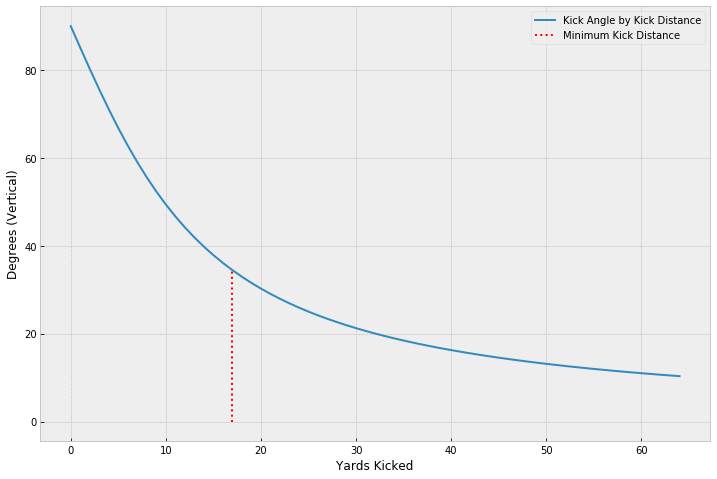

In [110]:
d = np.arange(0, 65, 1)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
ax.plot(d, radiants_to_degrees(get_kick_angle_vert(d)), label="Kick Angle by Kick Distance")

g = 10
m = g+7
m_x = radiants_to_degrees(get_kick_angle_vert(m))
ax.vlines(m, 0, m_x, color="red", linestyle="dotted", label="Minimum Kick Distance")

ax.set_xlabel("Yards Kicked")
ax.set_ylabel("Degrees (Vertical)")
ax.legend();

In [183]:
PLOT_SIZE

(12, 8)

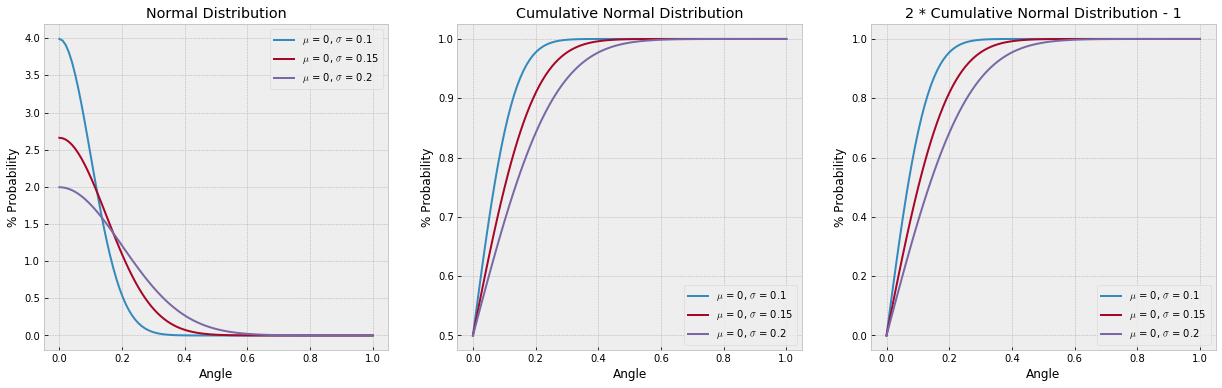

In [191]:
x = np.linspace(0, 1, 100)
mu = 0
sigmas = [0.1, .15, .2]
_, axes = plt.subplots(1, 3, figsize=(21, 6))

for sigma in sigmas:
    pdf = stats.norm.pdf(x, mu, sigma)
    cdf = stats.norm.cdf(x, mu, sigma)
    cdf2 = 2 * Phi(x/sigma) -1
    axes[0].plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
    axes[0].set_title("Normal Distribution")
    axes[1].plot(x, cdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
    axes[1].set_title("Cumulative Normal Distribution")
    axes[2].plot(x, cdf2, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
    axes[2].set_title("2 * Cumulative Normal Distribution - 1")
    for ax in axes:
        ax.set_xlabel("Angle")
        ax.set_ylabel("% Probability")
        ax.legend()


# vals = ax.get_yticks()
# _ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


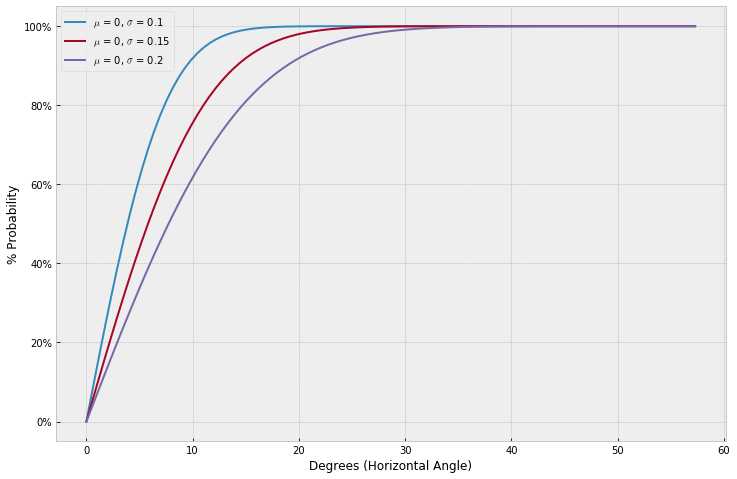

In [95]:
x = np.linspace(0, 1, 100)
mu = 0
sigmas = [0.1, .15, .2]
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
for sigma in sigmas:
    cdf = 2 * Phi(x/sigma) -1 #2 * stats.norm.cdf(x, mu, sigma)-1
    ax.plot(radiants_to_degrees(x), cdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))

vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Degrees (Horizontal Angle)")
ax.set_ylabel("% Probability")
ax.legend();

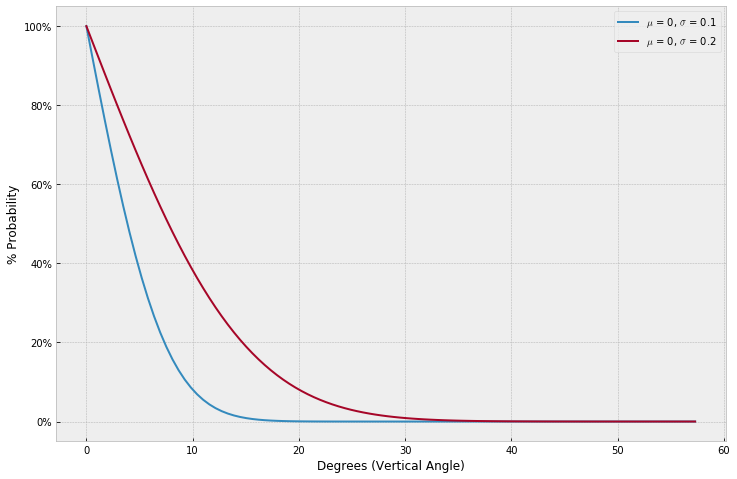

In [96]:
x = np.linspace(0, 1, 100)
mu = 0
# sigmas = [10, 20, 100, 200, 300]
sigmas = [0.1, .2]
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

for sigma in sigmas:
#     cdf = (2 * stats.norm.cdf(x, 0, sigma)-1)
    cdf = 1-(2* Phi(x/sigma)-1)
    ax.plot(radiants_to_degrees(x), cdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_xlabel("Degrees (Vertical Angle)")
ax.set_ylabel("% Probability")

ax.legend();

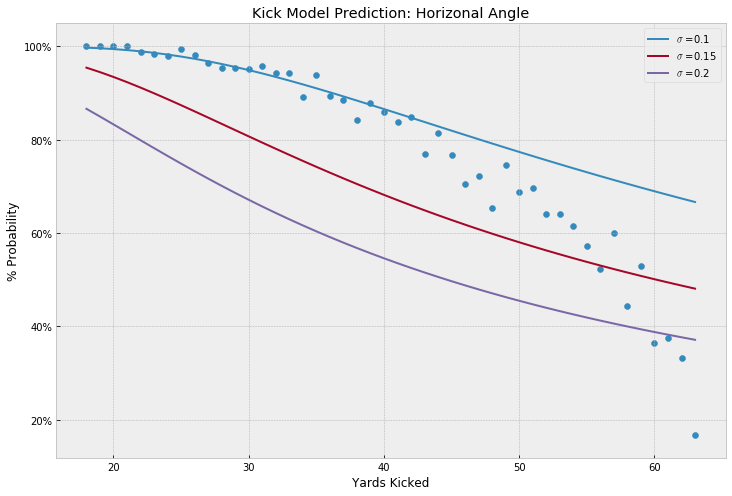

In [114]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"]
ax.scatter(d, df_train_yards["field_goals_success_percent"])
for v in (0.1, 0.15, 0.20):
    ax.plot(d, kick_angle_model_horiz(d, v), label=f"$\sigma$ ={v}")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")
ax.set_title("Kick Model Prediction: Horizonal Angle")
ax.legend()
pass

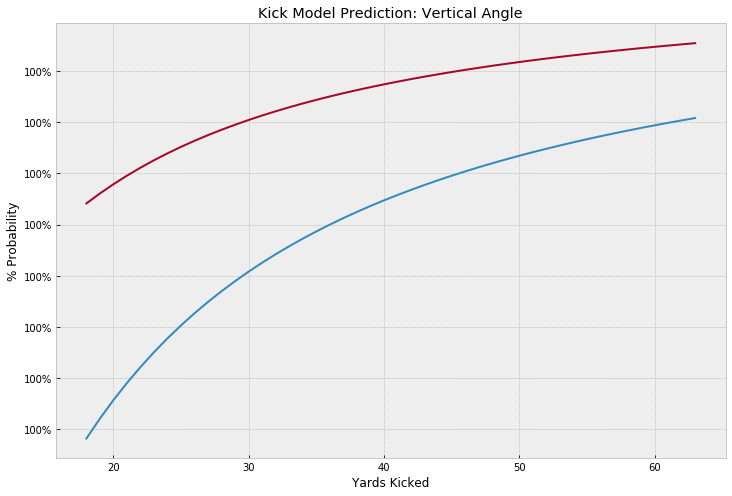

In [104]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"]
# ax.scatter(d, df_train_yards["field_goals_success_percent"])

for v in np.arange(100, 300, 100):
    ax.plot(d, kick_angle_model_vert(d, v), label=f"variance={v}")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")

ax.set_title("Kick Model Prediction: Vertical Angle");

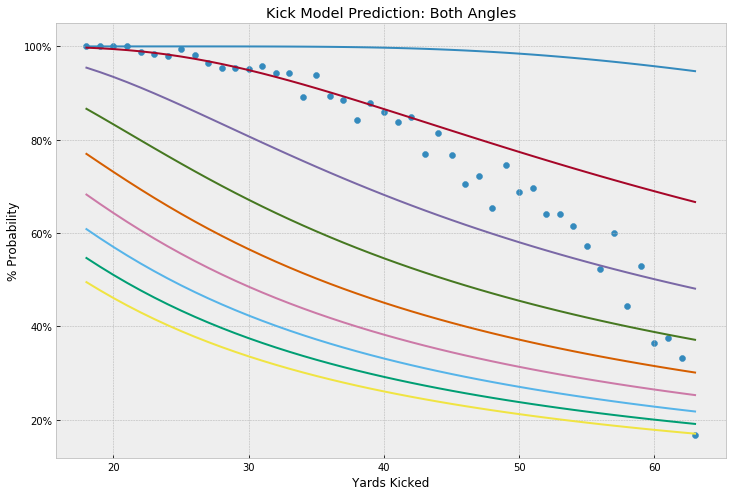

In [105]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"]
ax.scatter(d, df_train_yards["field_goals_success_percent"])
variances = zip(np.arange(.05, .5, .05), np.arange(100, 300, 10))
for v, h in variances:
    p = kick_angle_model_horiz(d, v) #* kick_angle_model_vert(d, h)
    ax.plot(d, p, label=f"variance={v} {h}")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")

ax.set_title("Kick Model Prediction: Both Angles")
# ax.legend()
pass

In [129]:
# 1 - Phi((- overshot) / 
#                 ((X_distance + overshot)*σ_distance))
#     ))
    
def kick_distance_model(distance, sigma):
    over_ft = 1
    distance_ft = distance*3
    u = over_ft/((distance_ft+over_ft)*sigma)
    return Phi(u)

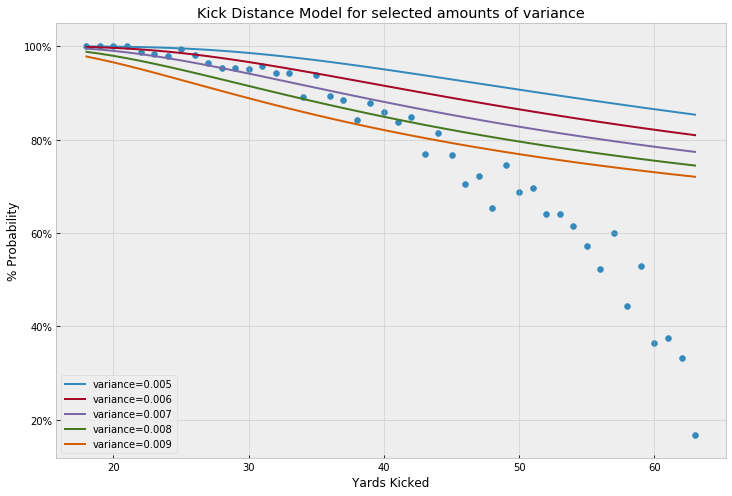

In [130]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"].values
ax.scatter(d, df_train_yards["field_goals_success_percent"])

for v in np.arange(0.005, .01, .001):
    ax.plot(d, kick_distance_model(d, v), label=f"variance={v:.3f}")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")
ax.set_title("Kick Distance Model for selected amounts of variance")
ax.legend()
pass

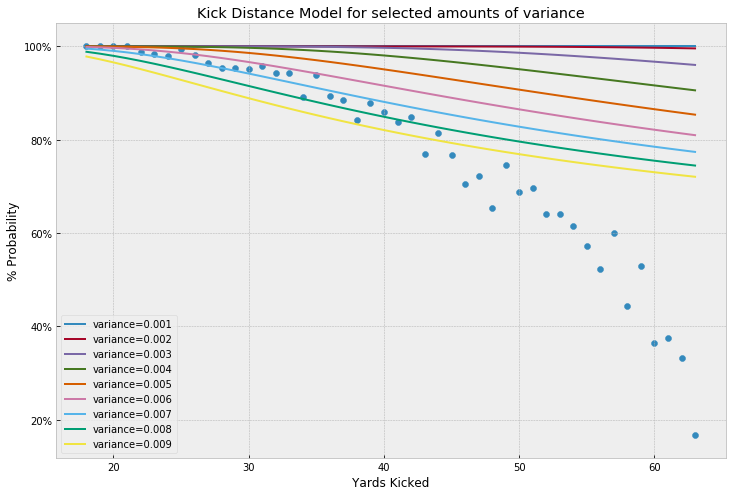

In [131]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"].values
ax.scatter(d, df_train_yards["field_goals_success_percent"])

for v in np.arange(0.001, .01, .001):
    ax.plot(d, kick_distance_model(d, v), label=f"variance={v:.3f}")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")
ax.set_title("Kick Distance Model for selected amounts of variance")
ax.legend()
pass

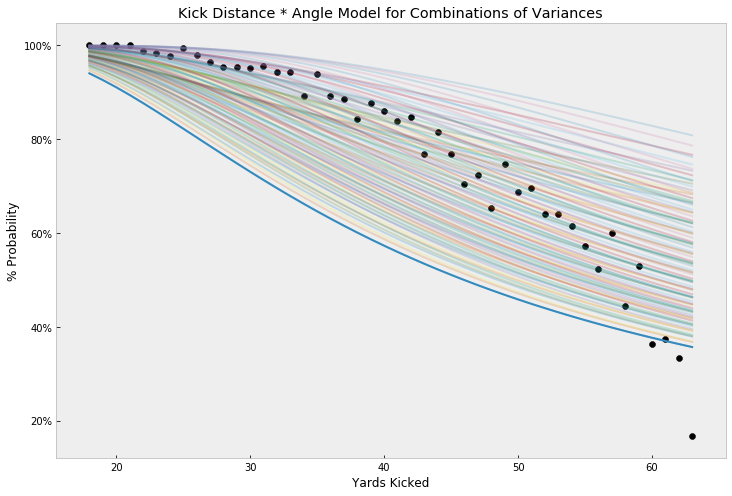

In [132]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"].values

for va in np.arange(.05, .15, .005):
    for vd in np.arange(0.005, .01, .001):
        ax.plot(d, kick_angle_model_horiz(d, va) * kick_distance_model(d, vd), label=f"variances={va:.3f} : {vd:.3f}", alpha=.2)

ax.plot(d, kick_angle_model_horiz(d, va) * kick_distance_model(d, vd), label=f"variances={va:.3f} : {vd:.3f}")

ax.scatter(d, df_train_yards["field_goals_success_percent"], color="black")
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlabel("Yards Kicked")
ax.set_ylabel("% Probability")
ax.set_title("Kick Distance * Angle Model for Combinations of Variances")

ax.grid(False)
# ax.legend()
pass

In [41]:
import theano.tensor as tt

def Phi_tt(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.))

In [42]:
X_kick_angle_horizontal = get_kick_angle_horiz(df_train_yards["kick_distance_yards"].values)
X_distance = df_train_yards["kick_distance_yards"].values

In [133]:
with pm.Model() as model_geo:

    σ_angle = pm.HalfNormal("σ_angle", sd=1)
    σ_distance = pm.HalfNormal("σ_distance", sd=1)

    over_ft = 1
    X_distance_ft = X_distance*3
    
    p_angle = pm.Deterministic("p_angle", (2 * Phi_tt(X_kick_angle_horizontal / σ_angle) - 1))
    u = (over_ft) / ((X_distance_ft + over_ft) * σ_distance)
    p_distance = pm.Deterministic("p_distance", Phi_tt(u))
    
    p = pm.Deterministic("p", p_angle * p_distance)
              
    y_obs = pm.Binomial("y_obs", n=n, p=p, observed=y)    

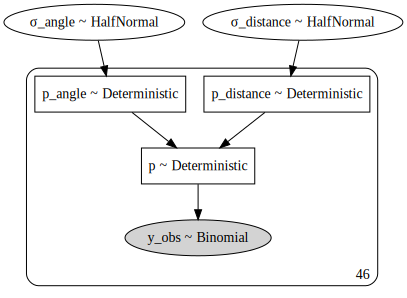

In [134]:
pm.model_to_graphviz(model_geo)

In [136]:
with model_geo:
    trace_geo = pm.sample(**get_sampler_config(5000), init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_distance, σ_angle]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [00:10<00:00, 2737.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


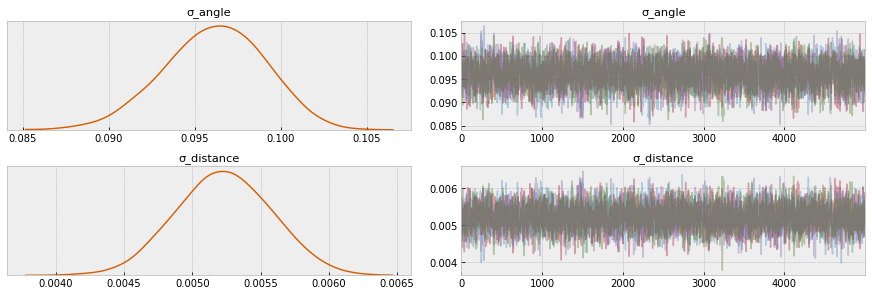

In [137]:
_ = az.plot_trace(trace_geo, combined=True, compact=True, divergences=None, var_names=["σ_angle", "σ_distance"], ); 

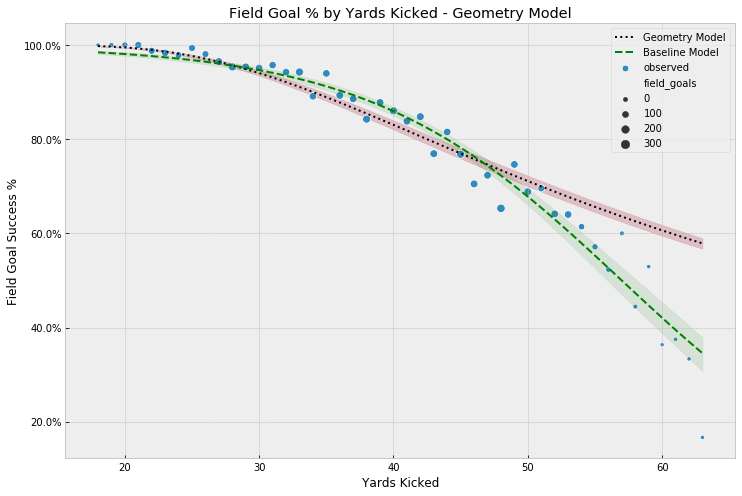

In [152]:
ax = plot_probs_yard(df_train_yards, trace_geo["p"], "Geometry Model")
ax.plot(d, trace_logit_yards["p"].mean(axis=0), label="Baseline Model", color="green", linestyle="dashed")
az.plot_hpd(d, trace_logit_yards["p"], credible_interval=.95, ax=ax, fill_kwargs={"color": "green", "alpha": .1})
# ax = plot_probs_yard(df_train_yards, trace_logit_yards["p"], "Baseline Model", ax=ax)
ax.legend()
pass
# va = trace_geo["σ_angle"].mean()
# vd = trace_geo["σ_distance"].mean()

# ax.plot(d, kick_angle_model_horiz(d, va) * kick_distance_model(d, vd), label=f"variances={va:.4f} : {vd:.4f}")
# ax = plot_probs_yard(df_train_yards, trace_geo["p_distance"], "Distance Only", ax=ax)
# ax = plot_probs_yard(df_train_yards, trace_geo["p_angle"], "Angle Only", ax=ax)

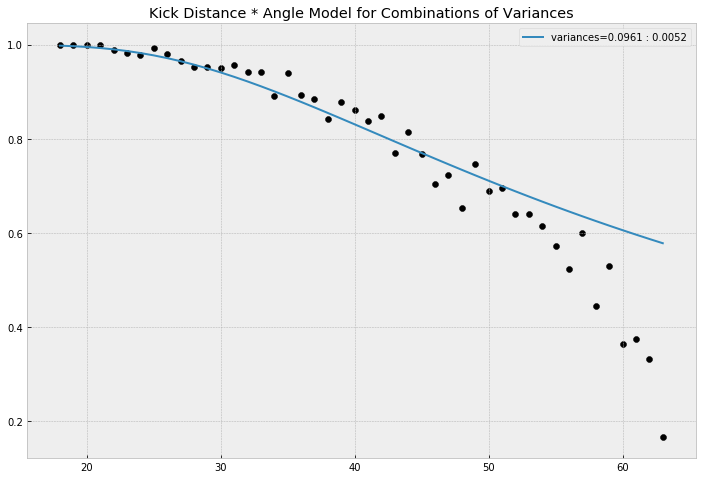

In [48]:
# ax = plot_kick_data(X, y_probs)
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

d = df_train_yards["kick_distance_yards"].values

# for va in np.arange(.05, .15, .005):
#     for vd in np.arange(0.005, .01, .001):
#         ax.plot(d, kick_angle_model_horiz(d, va) * kick_distance_model(d, vd), label=f"variances={va:.3f} : {vd:.3f}", alpha=.2)
va = trace_geo["σ_angle"].mean()
vd = trace_geo["σ_distance"].mean()

ax.plot(d, kick_angle_model_horiz(d, va) * kick_distance_model(d, vd), label=f"variances={va:.4f} : {vd:.4f}")

ax.set_title("Kick Distance * Angle Model for Combinations of Variances")
ax.scatter(d, df_train_yards["field_goals_success_percent"], color="black")
# ax.grid(False)
ax.legend()
pass

In [49]:
# df_train_yards["kick_distance_yards_xf"] = df_train_yards["kick_distance_yards"]**3

feature_columns = ["kick_distance_yards", "kick_angle_horizontal_degrees"]

X = df_train_yards[feature_columns]

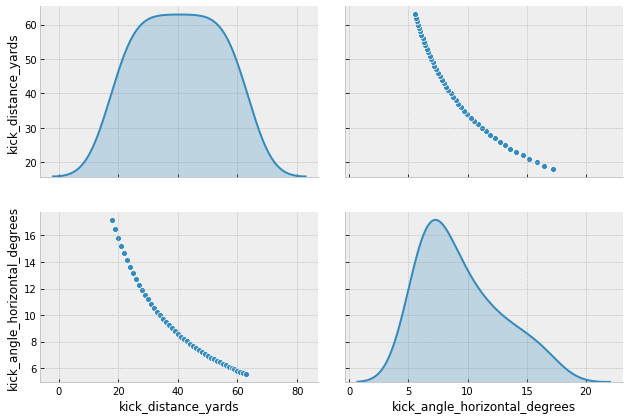

In [50]:
sns.pairplot(X, diag_kind="kde", height=3, aspect=1.5);

In [51]:
with pm.Model() as model_logit_yards_angle:

    α = pm.Normal("α", mu=0, sd=.1)
    β = pm.Normal("β", mu=0, sd=.1, shape=X.shape[1])

    z = α + pm.math.dot(X, β)

    p = pm.Deterministic("p", pm.math.invlogit(z))

    y_obs = pm.Binomial("y_obs", n=n, p=p, observed=y)

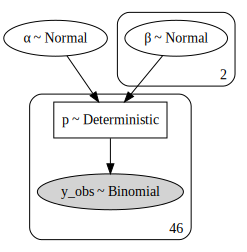

In [52]:
pm.model_to_graphviz(model_logit_yards_angle)

In [53]:
with model_logit_yards_angle:
    trace_logit_yards_angle = pm.sample(**get_sampler_config(5000), init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [00:19<00:00, 1500.74draws/s]


In [153]:
pm.summary(trace_logit_yards_angle, var_names=["α", "β"], kind="stats")

,mean,sd,hpd_3%,hpd_97%
α,0.024,0.099,-0.159,0.212
β[0],-0.037,0.002,-0.041,-0.032
β[1],0.366,0.013,0.342,0.391


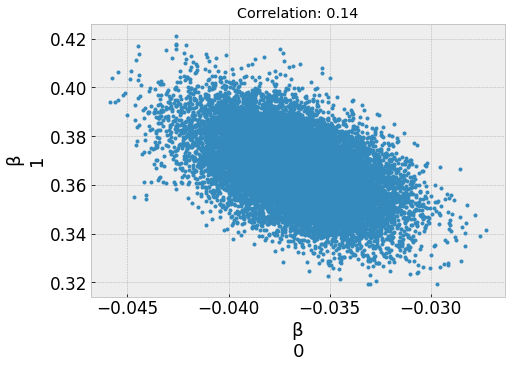

In [154]:
ax = pm.plot_pair(trace_logit_yards_angle, var_names=["β"], figsize=(7, 5))
corr = np.correlate(trace_logit_yards_angle["β"][0], trace_logit_yards_angle["β"][1])[0]
ax.set_title(f"Correlation: {corr:,.2f}");
pass

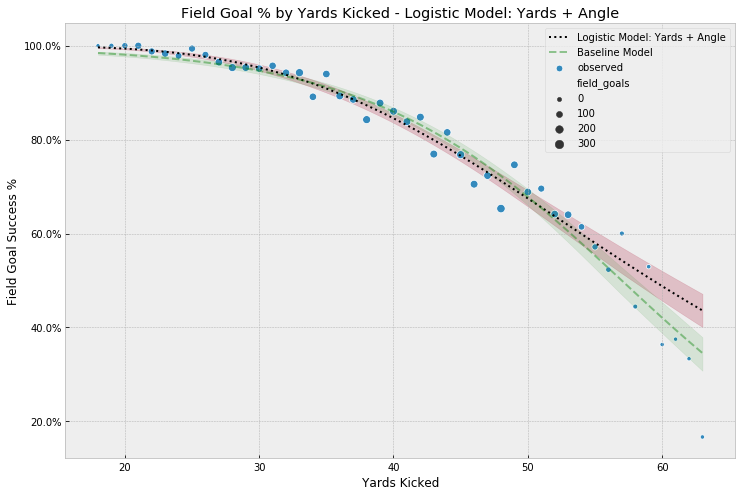

In [157]:
ax = plot_probs_yard(df_train_yards, trace_logit_yards_angle["p"], "Logistic Model: Yards + Angle")
ax.plot(d, trace_logit_yards["p"].mean(axis=0), label="Baseline Model", color="green", linestyle="dashed", alpha=0.4)
az.plot_hpd(d, trace_logit_yards["p"], credible_interval=.95, ax=ax, fill_kwargs={"color": "green", "alpha": .1})
# ax = plot_probs_yard(df_train_yards, trace_logit_yards["p"], "Baseline Model", ax=ax)
ax.legend()
pass

In [57]:
df_train_yards["kick_distance_yards_angle"] = df_train_yards["kick_distance_yards"] * df_train_yards["kick_angle_horizontal_degrees"]

feature_columns = ["kick_distance_yards", "kick_angle_horizontal_degrees", "kick_distance_yards_angle"]
X = df_train_yards[feature_columns]

In [58]:
with pm.Model() as model_logit_yards_angle_interactions:

    α = pm.Normal("α", mu=0, sd=.1)
    β = pm.Normal("β", mu=0, sd=.1, shape=X.shape[1])

    z = α + pm.math.dot(X, β)

    p = pm.Deterministic("p", pm.math.invlogit(z))

    y_obs = pm.Binomial("y_obs", n=n, p=p, observed=y)

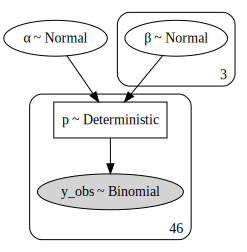

In [59]:
pm.model_to_graphviz(model_logit_yards_angle_interactions)

In [60]:
with model_logit_yards_angle_interactions:
    trace_logit_yards_angle_interactions = pm.sample(**get_sampler_config(5000), init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:32<00:00, 324.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [158]:
pm.summary(trace_logit_yards_angle_interactions, var_names=["α", "β"], kind="stats")

,mean,sd,hpd_3%,hpd_97%
α,0.003,0.102,-0.193,0.189
β[0],-0.067,0.013,-0.092,-0.043
β[1],0.237,0.056,0.131,0.343
β[2],0.007,0.003,0.001,0.012


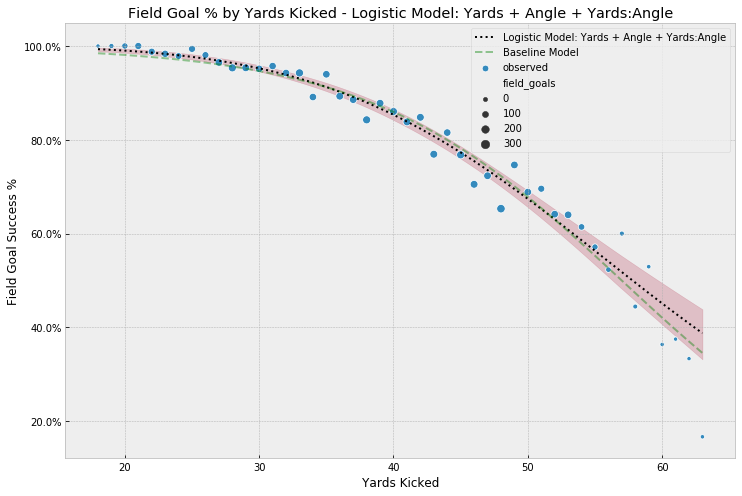

In [160]:
ax = plot_probs_yard(df_train_yards, trace_logit_yards_angle_interactions["p"], "Logistic Model: Yards + Angle + Yards:Angle")
ax.plot(d, trace_logit_yards["p"].mean(axis=0), label="Baseline Model", color="green", linestyle="dashed", alpha=0.4)
# az.plot_hpd(d, trace_logit_yards["p"], credible_interval=.95, ax=ax, fill_kwargs={"color": "green", "alpha": .1})
# ax = plot_probs_yard(df_train_yards, trace_logit_yards["p"], "Baseline Model", ax=ax)
ax.legend()
pass

In [63]:
def plot_trace(df, trace, label, ax=None):

    ax.plot(df["kick_distance_yards"], trace["p"].mean(axis=0), label=label, linestyle="dashed")
    
def plot_probs_traces(traces, df, ax=None):
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
    for k, trace in traces.items():
        plot_trace(df, trace, k, ax)
    
    ax = plot_kick_data(df, ax)

    ax.legend()
    
    return ax

In [161]:
compare_dict = {"Logistic Model: Distance": trace_logit_yards, 
                "Geometry Model: Distance + Angle": trace_geo,
                "Logistic Model: Distance + Angle": trace_logit_yards_angle,
                "Logistic Model: Distance + Angle + Distance*Angle)": trace_logit_yards_angle_interactions

               }
df_compare = az.compare(compare_dict, ic="loo")
df_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Logistic Model: Distance + Angle,0,228.841,1.75812,0,0.77498,14.2716,0,False,deviance
Logistic Model: Distance + Angle + Distance*Angle),1,232.431,2.47292,3.58986,0.218909,17.7938,3.38986,False,deviance
Logistic Model: Distance,2,245.913,2.30069,17.0723,0.00591813,13.0178,8.18756,False,deviance
Geometry Model: Distance + Angle,3,265.955,1.72636,37.1137,0.000192835,13.3825,10.6327,False,deviance


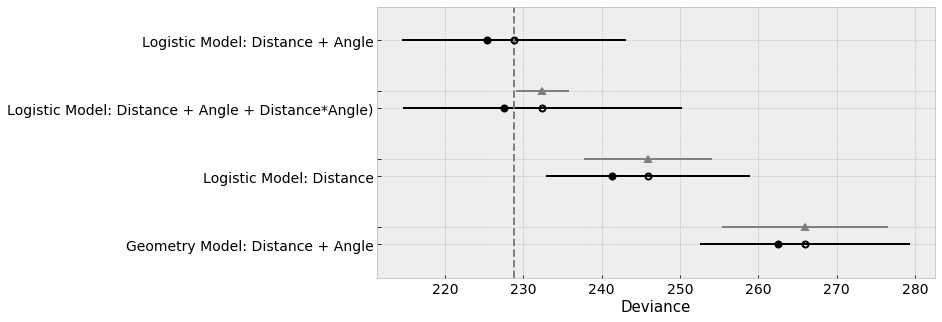

In [166]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
az.plot_compare(df_compare, ax=ax);

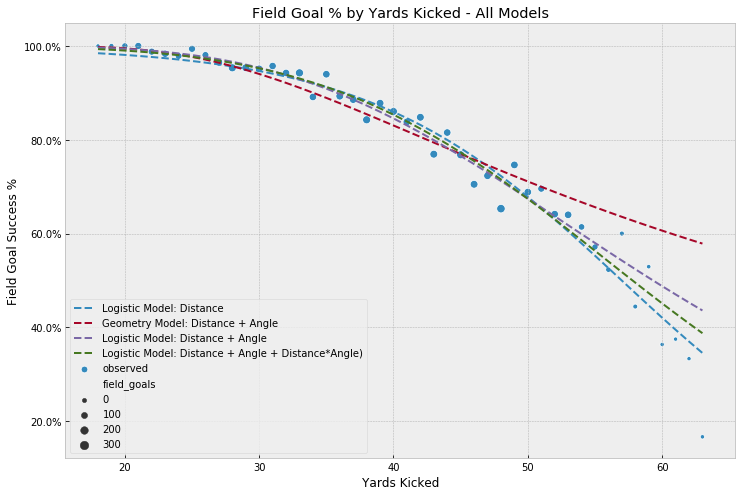

In [162]:
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)
_ = plot_probs_traces(compare_dict, df_train_yards, ax=ax)
ax.set_title(f"{ax.get_title()} - All Models");

In [66]:
models_subset = df_compare.index[:3].to_list()

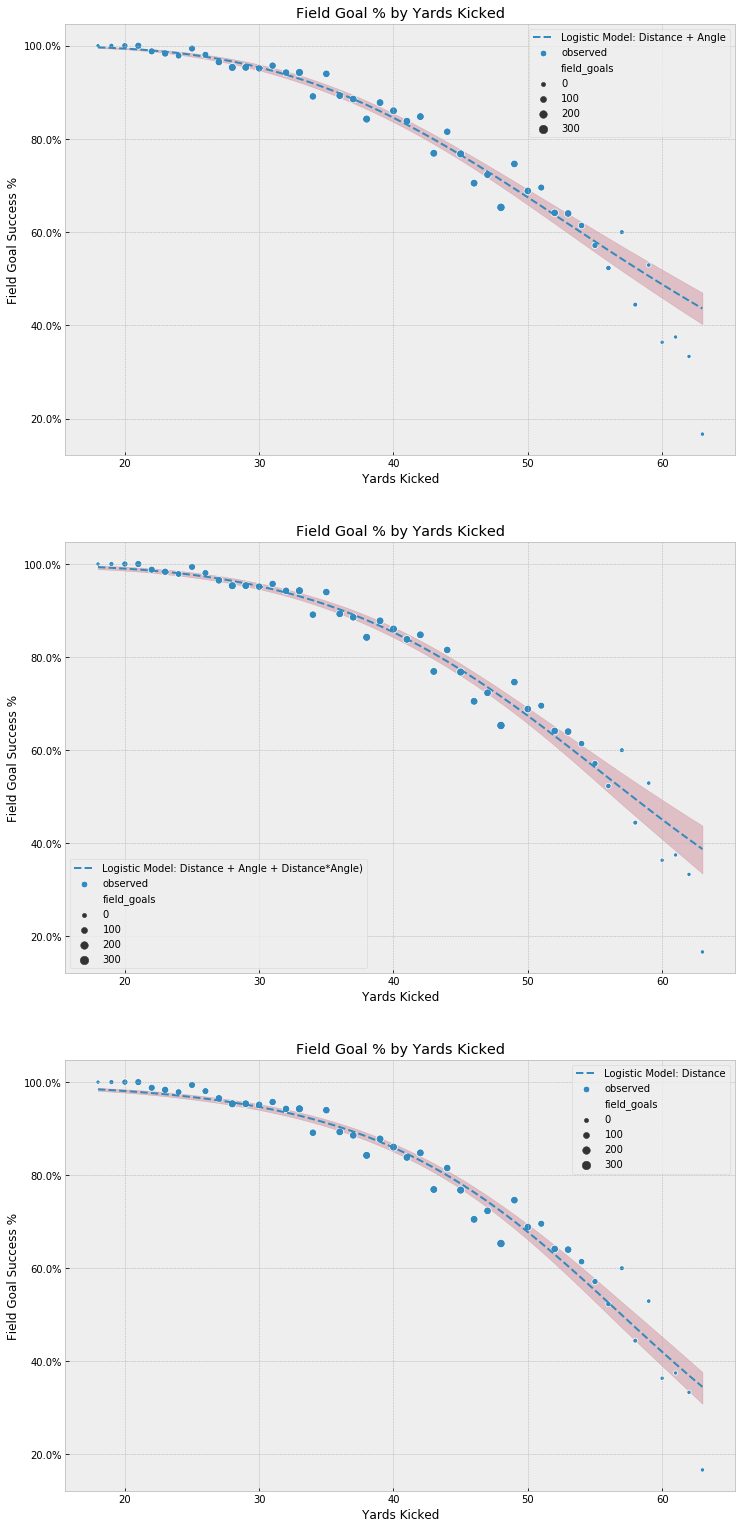

In [67]:
# _, axes = plt.subplots(1, len(models_subset), figsize=(24, 9))
_, axes = plt.subplots(len(models_subset), 1, figsize=(12, 27))

X = df_train_yards["kick_distance_yards"]

for i, model_name in enumerate(models_subset):
    ax = axes[i]
    trace = compare_dict[model_name]
    az.plot_hpd(X, trace["p"], fill_kwargs={"alpha":.2}, ax=ax)
    plot_trace(df_train_yards, trace, model_name, ax)
    _ = plot_kick_data(df_train_yards, ax)
#     ax.set_title(f"{ax.get_title()} - {model_name}")

In [168]:
models_subset = df_compare.index[:2].to_list()

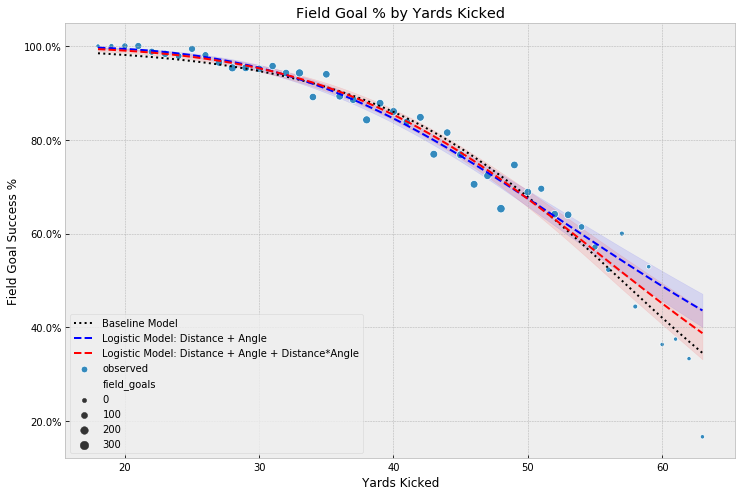

In [174]:
_, ax = plt.subplots(1, 1, figsize=PLOT_SIZE)

X = df_train_yards["kick_distance_yards"]

ax.plot(d, trace_logit_yards["p"].mean(axis=0), label="Baseline Model", color="black", linestyle="dotted")

az.plot_hpd(X, trace_logit_yards_angle["p"],  credible_interval=.95, fill_kwargs={"color": "blue", "alpha":.1}, ax=ax)
ax.plot(d, trace_logit_yards_angle["p"].mean(axis=0), label="Logistic Model: Distance + Angle", color="blue", linestyle="dashed")

az.plot_hpd(X, trace_logit_yards_angle_interactions["p"],  credible_interval=.95, fill_kwargs={"color": "red", "alpha":.1}, ax=ax)
ax.plot(d, trace_logit_yards_angle_interactions["p"].mean(axis=0), label="Logistic Model: Distance + Angle + Distance*Angle", color="red", linestyle="dashed")


_ = plot_kick_data(df_train_yards, ax)
#     ax.set_title(f"{ax.get_title()} - {model_name}")